# Jupyter Notebook 6: AWS Notebook for ML Baseline Models - This has moved to AWS. 

---

# Introduction

This Notebook is used to get a baseline model for use in the real time section of the project.

4 models will be run, first with a baseline model and then with a Search for the best tuning parameters.
   - 1) Random Forest Model
   - 2) K-Means Model
   - 3) Isolate Forest Model
   - 4) One Class SVM Model
   
Previous research has shown very high accuracy results from models so this will be expected from these models. The previous studies did not discuss the Data Preprocessing steps in enough detail to explore why this is the case.

The data is highly imbalanced which is accepted for this study as this is a real world representation of network traffic in the real world. 

The Results will be stored to be the local SQL Database for comparison later on the Dashboard.

---

# Load data and pretraining steps

In [66]:
# General
import os
import time

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt

# Data Types
import json
import mysql.connector
from joblib import dump, load
import pickle


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Getting metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix as cm_function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.metrics import precision_recall_curve

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Location of preprocessed file
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Notebooks"
file_path = os.path.join(folder_path, "ids_2018_baseline_data.parquet")

# load data
data = pd.read_parquet(file_path, engine="pyarrow")

---

# Train and Test Split 80:20 Split

Create a Train and Test split with 80:20 to create baseline models.

As the minority class has a large imbalanced, its important to keep the percentage right in each train and val split.

In [27]:
# Seperate the x and y features
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [28]:
# Create the splits

# Train and val_test split
train_x, val_test_x, train_y, val_test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Validation and Test split
val_x, test_x, val_y, test_y = train_test_split(val_test_x, val_test_y, test_size=0.5, random_state=42, stratify=val_test_y)

In [16]:
# # Get a sample an save to file.
# sample_data_10_perc = train_x.sample(frac=0.01, random_state=42)
# sample_data_10_perc.shape
# file_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\sample_file.pkl'
# sample_data_10_perc.to_pickle(file_path)

---

# Open connection to Database

In [17]:
config = {
    "user":"root",
    "password":"root",
    "host": "localhost",
    "database":"mtu_capstone_db",
    "raise_on_warnings":True
}

In [18]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()

In [19]:
# Test the connection

try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    
    # Test Query - Different types
    # cursor.execute("SELECT VERSION();")
    # cursor.execute("SELECT * FROM baseline_model_results;") # This query exceeds the limit.
    # cursor.execute("SELECT * FROM baseline_model_results LIMIT 1;")  # Limit to 10 rows
    cursor.execute("SELECT COUNT(*) FROM baseline_model_results;")
    
    #Fetch the results - Differnt for above.
    # version = cursor.fetchone()
    # select_all = cursor.fetchone()
    # select_all = cursor.fetchall()  # Use fetchall() or fetchmany(size)
    number_of_rows = cursor.fetchone()[0]

    # print("My SQL Server version:", version)
    # print("Select all:", select_all)
    print("Number of rows in 'baseline_model_results':", number_of_rows)
    
except mysql.connector.Error as err:
    print("Error:", err)
    
else:
    cursor.close()
    cnx.close()

Number of rows in 'baseline_model_results': 17


## Insert data to database with a function

Create a function to send the data to the database. This will be used in this notebook for the baseline models and then later modified to be used with the live streaming models.

In [59]:
# create model results funciton.
def insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time,  
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot):
    
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO baseline_model_results
            (model_name, model_parameters, confusion_matrix, 
            accuracy_value, precision_value, recall_value, f1_value, 
            ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
            silhouette_score, cluster_centers, elbow_method_results, 
            cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
            decision_function_values, support_vectors, one_class_svm_plot) 
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, 
                    %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_parameters, confusion_matrix,
            accuracy_value, precision_value, recall_value, f1_value, 
            ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
            silhouette_score, cluster_centers, elbow_method_results, 
            cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
            decision_function_values, support_vectors, one_class_svm_plot)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

# **Random Forest Basic Model**

## Basic Model

For this model we as it is a basic model only uses a train and test dataset. 

In [25]:
# Initialise the random forest model
rf_model_basic = RandomForestClassifier(n_estimators=100, random_state=42)

In [26]:
# # Fit the model on the training data
rf_model_basic.fit(train_x, train_y)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Kolobane\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Kolobane\AppData\Local\Temp\ipykernel_12460\3374088346.py", line 2, in <module>
    rf_model_basic.fit(train_x, train_y)
  File "C:\Users\Kolobane\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 473, in fit
    for i, t in enumerate(trees)
  File "C:\Users\Kolobane\anaconda3\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    for delayed_func, args, kwargs in iterable
  File "C:\Users\Kolobane\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Kolobane\anaconda3\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Kolobane\anaconda3\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    jo

In [ ]:
# Test the model against the test 
test_predications = rf_model_basic.predict(val_test_x)

## Explore the results

### Name of the model

In [ ]:
model_name = "rf_model_baseline_basic"

In [ ]:
model_name

### Model Parameters

In [ ]:
model_parameters = "n_estimators=100"

In [ ]:
confusion_matrix = confusion_matrix(val_test_y, test_predications)

In [ ]:
confusion_matrix = confusion_matrix.tolist()

In [ ]:
confusion_matrix = json.dumps(confusion_matrix)

In [ ]:
accuracy_value = float(accuracy_score(val_test_y, test_predications))
precision_value = float(precision_score(val_test_y, test_predications))
recall_value = float(recall_score(val_test_y, test_predications))
f1_value = float(f1_score(val_test_y, test_predications))

In [ ]:
accuracy_value, precision_value, recall_value, f1_value

In [ ]:
fpr, tpr, thresholds = roc_curve(val_test_y, rf_model_basic.predict_proba(val_test_x)[:,1])
auc_score = float(auc(fpr, tpr))
auc_score

In [ ]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Send the ROC Curve to the DB as a JSON object.

# convert the ROC Curve to JSON
roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_auc": auc_score
}


ruc_curve = json.dumps(roc_data)

In [ ]:
precision, recall, _ = precision_recall_curve(val_test_y, rf_model_basic.predict_proba(val_test_x)[:,1])

In [ ]:
# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Send the Precision Recall Curve to the DB as a JSON object.

pr_data = {
    "precision": precision.tolist(), 
    "recall": recall.tolist()
}


precision_recall_curve = json.dumps(pr_data)

In [ ]:
feature_importances = rf_model_basic.feature_importances_

In [ ]:
feature_importances

In [ ]:
type(feature_importances)

In [ ]:
# Send the feature_importances to the DB as a JSON object.


In [ ]:
print(feature_importance)

### Model Training Time

In [ ]:
# get the start time
start_time = time.time()

# run the model
# Fit the model on the training data
rf_model_basic.fit(train_x, train_y)

# record the end time.
end_time = time.time()

In [ ]:
training_time = end_time - start_time

In [ ]:
training_time

In [ ]:
model_training_time = training_time
model_training_time

In [ ]:
print("Training time: ", model_training_time, "seconds")

In [ ]:
print("Training time: ", model_training_time/60, "minutes")

In [ ]:
print("Training time: ", model_training_time/60, "hours")

### Sent Results to DB

In [ ]:
# Kemans
silhouette_score = None
cluster_centers = None
elbow_method_results = None
cluster_visualisation_plot = None

# Isolate Forest
anomaly_score = None
anomaly_detection_plot = None

# One Class SVM
decision_function_values = None
support_vectors = None
one_class_svm_plot = None

In [ ]:
# Need to check the object types so that the DB can handle them

#DONE. Objects ok now.

# print(type(model_name))
# print(type(model_parameters))
# print(type(confusion_matrix))
# print(type(accuracy_value))
# print(type(precision_value))
# print(type(recall_value))
# print(type(f1_value))
# print(type(ruc_curve))
# print(type(auc_score))
# print(type(precision_recall_curve))
# print(type(feature_importance))
# print(type(model_training_time))
# print(type(silhouette_score)) 
# print(type(cluster_centers))
# print(type(elbow_method_results))
# print(type(cluster_visualisation_plot)) 
# print(type(anomaly_score))
# print(type(anomaly_detection_plot))
# print(type(decision_function_values)) 
# print(type(support_vectors))
# print(type(one_class_svm_plot))

In [ ]:
insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot)

## Save Model

In [ ]:
# save model to file.

#save folder location
model_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\rf_model_basic.joblib"

# save model
dump(rf_model_basic, model_path)


In [ ]:
# load this model
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "rf_model_basic.joblib"
model = os.path.join(folder_path, model_name)

In [ ]:
loaded_model = load(model)

In [ ]:

# Check the number of features
num_features = model.n_features_

---

#  **Random Forest Best Model Search**

The Baseline Random Forest Model has done very well with an accuracy of 99% so for now I will not look at improving this model. Time being short. 

## GridSearch of RF Models

In [ ]:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

---

# **K-Means Basic Model**

## Basic Model with 2 clusters

In [66]:
# Intialise Kmeans model
kmeans_model_baseline_basic = KMeans(n_clusters=2, random_state=42)

In [67]:
# This runs the model and gets the training time as well.

# start timer
start_time = time.time()

# train the model
kmeans_model_baseline_basic.fit(train_x)

# end timer
end_time = time.time()

In [68]:
# Predictions on the test data
predictions = kmeans_model_baseline_basic.predict(test_x)

In [69]:
predictions

array([1, 1, 0, ..., 1, 1, 1])

## Explore the Results

In [70]:
# Evaluate the model using Silhouette Score
silhouette_avg = silhouette_score(test_x, predictions)

TypeError: 'float' object is not callable

In [ ]:
silhouette_avg

The silhouette score is a metric to calculate the goodness of a clustering technique. Its range is fom -1 to 1. A value close to 1  indicates that the data points are very far away from  neighbouring clusters. This means the clusters are distinct and well seperated, which usually represents a good clustering.

0.42 indicates that there is a good struture of clusters seperated from each other.

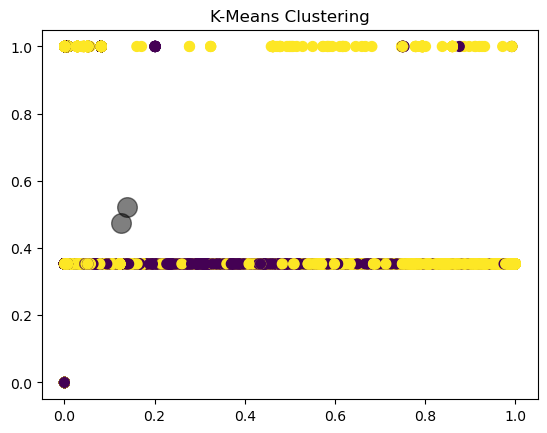

In [71]:
# Visualizations specific to K-Means
plt.scatter(test_x.iloc[:, 0], test_x.iloc[:, 1], c=predictions, s=50, cmap='viridis')
centers = kmeans_model_baseline_basic.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('K-Means Clustering')
plt.show()

In [72]:
# convert to a json object for the database

# Extracting data points
data_points_x = test_x.iloc[:, 0].tolist()  # First feature values
data_points_y = test_x.iloc[:, 1].tolist()  # Second feature values

# Extracting cluster centers
centers_x = centers[:, 0].tolist()  # X-coordinates of cluster centers
centers_y = centers[:, 1].tolist()  # Y-coordinates of cluster centers

# Organize data into a structured dictionary
visualization_data = {
    "data_points": {
        "x": data_points_x,
        "y": data_points_y,
        "cluster": predictions.tolist()  # Cluster assignments
    },
    "cluster_centers": {
        "x": centers_x,
        "y": centers_y
    }
}

# Convert to JSON
cluster_visualisation = json.dumps(visualization_data)

In [ ]:
# model_training_time
model_training_time = end_time - start_time

In [ ]:
model_training_time 

In [ ]:
# Silhouette time
silhouette_score_db = float(silhouette_avg) 
silhouette_score_db

In [ ]:
# cluster centers
cluster_centers = kmeans_model_baseline_basic .cluster_centers_.tolist() 
cluster_centers = json.dumps(cluster_centers) 
cluster_centers

In [ ]:
# elbow method resutls

wcss = []
for i in range(1, 11):  # Example: Test for 1 to 10 clusters
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(train_x)
    wcss.append(km.inertia_)
elbow_method_results = json.dumps(wcss) 

In [ ]:
elbow_method_results

## Sent Results to DB

In [ ]:
# Need to check the object types so that the DB can handle them

#DONE. Objects ok now.

# print(type(model_name))
# print(type(model_parameters))
# print(type(confusion_matrix))
# print(type(accuracy_value))
# print(type(precision_value))
# print(type(recall_value))
# print(type(f1_value))
# print(type(ruc_curve))
# print(type(auc_score))
# print(type(precision_recall_curve))
# print(type(feature_importance))
# print(type(model_training_time))
# print(type(silhouette_score)) 
# print(type(cluster_centers))
# print(type(elbow_method_results))
# print(type(cluster_visualisation_plot)) 
# print(type(anomaly_score))
# print(type(anomaly_detection_plot))
# print(type(decision_function_values)) 
# print(type(support_vectors))
# print(type(one_class_svm_plot))

In [ ]:
model_parameters_update = json.dumps(kmeans_model_baseline_basic.get_params())

In [ ]:
model_name = "kmeans_model_baseline_basic"
model_parameters = model_parameters_update
confusion_matrix = None  # Not applicable for K-Means, same below.
accuracy_value = None 
precision_value = None
recall_value = None
f1_value = None
ruc_curve = None
auc_score = None
precision_recall_curve = None
feature_importance = None
model_training_time = model_training_time

silhouette_score = silhouette_score_db
cluster_centers = cluster_centers
elbow_method_results = elbow_method_results
cluster_visualisation_plot = cluster_visualisation 

anomaly_score = None
anomaly_detection_plot = None

decision_function_values = None
support_vectors = None
one_class_svm_plot = None

In [ ]:
# # test the conneciton
# try:
#     cnx = mysql.connector.connect(**config)
#     cursor = cnx.cursor()
#     cursor.execute("SELECT 1;")
#     result = cursor.fetchone()
#     print(result)
# except mysql.connector.Error as err:
#     print("Error:", err)
# finally:
#     cursor.close()
#     cnx.close()

In [ ]:
# call and save to DB
insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot)

## Save Model

In [ ]:
# save model to file.

#save folder location
model_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\kmeans_model_baseline_basic.joblib"

# save model
dump(kmeans_model_baseline_basic, model_path)

---

# **K-Means Best Model Search**

Look at improving the kmeans model by looking at the opitmal number of clusters and other hyper-parameters. Some parameters to explore:
1) Determine the Range for "n_clusters": No need to change this, there are attack and benign groups so 2 clusters. However, its still worth exploring other numbers of clusters.

2) Iternate over other values for "n_cluster".

3) Other Hyperparameters. There are other clusters that are less important but worth trying. "init" (method for initialization), "n_init" (number of time the k-means algorithm will be run with different centroid seeds) and "max_iter". 

4) Choose best kmeans model.

## GridSearch for Best Model

In [ ]:
# range of clusters to try
cluster_range = range(2,6)

# Store the average silhouetter scores
silhouette_avg_scores = []

# store the inertias (sum of the distances)
inertias = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_x)
    cluster_labels = kmeans.predict(test_x)
    
    silhouette_avg = silhouette_score(test_x, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    
    inertias.append(kmeans.inertia_)  # Corrected this line
    
# Plotting the results
# Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_avg_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Inertia
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_avg_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.savefig('silhouette_scores.png')
plt.show()

In [ ]:
# Inertia
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('inertia.png')
plt.show()

##### Get the best model

Reading the plots We will choose the 5 clusters as our best model. While this seems large for the domain it might give more interesting results as the silhouette score is higher.

## Rerun the best model

In [ ]:
# Intialise Kmeans model
kmeans_model_baseline_best_serach = KMeans(n_clusters=5, random_state=42)

In [ ]:
# This runs the model and gets the training time as well.

# start timer
start_time = time.time()

# train the model
kmeans_model_baseline_best_serach.fit(train_x)

# end timer
end_time = time.time()

In [ ]:
# Predictions on the test data
predictions = kmeans_model_baseline_best_serach.predict(test_x)

In [ ]:
predictions

In [ ]:
# Evaluate the model using Silhouette Score
silhouette_avg = silhouette_score(test_x, predictions)

In [ ]:
silhouette_avg

improvement on the 42 in 2 clusters

## Explore the Results

In [ ]:
# Visualizations specific to K-Means
plt.scatter(test_x.iloc[:, 0], test_x.iloc[:, 1], c=predictions, s=50, cmap='viridis')
centers = kmeans_model_baseline_best_serach.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('K-Means Clustering')
plt.show()

In [ ]:
# convert to a json object for the database

# Extracting data points
data_points_x = test_x.iloc[:, 0].tolist()  # First feature values
data_points_y = test_x.iloc[:, 1].tolist()  # Second feature values

# Extracting cluster centers
centers_x = centers[:, 0].tolist()  # X-coordinates of cluster centers
centers_y = centers[:, 1].tolist()  # Y-coordinates of cluster centers

# Organize data into a structured dictionary
visualization_data = {
    "data_points": {
        "x": data_points_x,
        "y": data_points_y,
        "cluster": predictions.tolist()  # Cluster assignments
    },
    "cluster_centers": {
        "x": centers_x,
        "y": centers_y
    }
}

# Convert to JSON
cluster_visualisation = json.dumps(visualization_data)

In [64]:
# model_training_time
model_training_time = end_time - start_time
model_training_time

5.784250736236572

In [ ]:
# Silhouette time
silhouette_score_db = float(silhouette_avg) 
silhouette_score_db

In [ ]:
# cluster centers
cluster_centers = kmeans_model_baseline_best_serach.cluster_centers_.tolist() 

In [ ]:
cluster_centers = json.dumps(cluster_centers) 
cluster_centers

In [ ]:
type(cluster_centers)

In [ ]:
# elbow method resutls

wcss = []
for i in range(1, 11):  # Example: Test for 1 to 10 clusters
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(train_x)
    wcss.append(km.inertia_)
elbow_method_results = json.dumps(wcss)  #

In [ ]:
elbow_method_results

In [ ]:
model_parameters_update = json.dumps(kmeans_model_baseline_best_serach.get_params())

In [ ]:
model_name = "kmeans_model_baseline_best_serach"
model_parameters = model_parameters_update
confusion_matrix = None  # Not applicable for K-Means, same below.
accuracy_value = None 
precision_value = None
recall_value = None
f1_value = None
ruc_curve = None
auc_score = None
precision_recall_curve = None
feature_importance = None
model_training_time = model_training_time

silhouette_score = silhouette_score_db
cluster_centers = cluster_centers
elbow_method_results = elbow_method_results
cluster_visualisation_plot = cluster_visualisation 

anomaly_score = None
anomaly_detection_plot = None

decision_function_values = None
support_vectors = None
one_class_svm_plot = None

In [ ]:
# Need to check the object types so that the DB can handle them

#DONE. Objects ok now.

print(type(model_name))
print(type(model_parameters))
print(type(confusion_matrix))
print(type(accuracy_value))
print(type(precision_value))
print(type(recall_value))
print(type(f1_value))
print(type(ruc_curve))
print(type(auc_score))
print(type(precision_recall_curve))
print(type(feature_importance))
print(type(model_training_time))
print(type(silhouette_score)) 
print(type(cluster_centers))
print(type(elbow_method_results))
print(type(cluster_visualisation_plot)) 
print(type(anomaly_score))
print(type(anomaly_detection_plot))
print(type(decision_function_values)) 
print(type(support_vectors))
print(type(one_class_svm_plot))

##### Connect to DB and send results

In [ ]:
config = {
    "user":"root",
    "password":"root",
    "host": "localhost",
    "database":"mtu_capstone_db",
    "raise_on_warnings":True
}

In [ ]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()

In [ ]:
# call and save to DB
insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot)

## Save model

In [ ]:
# save model to file.

#save folder location
model_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\kmeans_model_baseline_best_serach.joblib"

# save model
dump(kmeans_model_baseline_best_serach, model_path)

---

# **Isolate Forest  Basic Model: Attempt 3**

## Basic Model

In [27]:
# Initialise the IF model
iso_model_baseline_basic = IsolationForest(n_estimators=100, random_state=42)

In [28]:
# Fit the model and get the training time.

# start timer
start_time = time.time()

# train the model
iso_model_baseline_basic.fit(train_x)

# end timer
end_time = time.time()

In [29]:
# Prediations and Evualations
predictions = iso_model_baseline_basic.predict(test_x)

In [30]:
# Convert prredictions to make the labels
predictions = [1 if p==-1 else 0 for p in predictions]

In [31]:
# If you have true labels (test_y), you can evaluate the model
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84    669513
           1       0.12      0.09      0.10    137347

    accuracy                           0.73    806860
   macro avg       0.47      0.48      0.47    806860
weighted avg       0.70      0.73      0.72    806860



## Explore Results

In [32]:
model_name = "iso_model_baseline_basic"

In [33]:
model_parameters = json.dumps(iso_model_baseline_basic.get_params())
model_parameters

'{"bootstrap": false, "contamination": "auto", "max_features": 1.0, "max_samples": "auto", "n_estimators": 100, "n_jobs": null, "random_state": 42, "verbose": 0, "warm_start": false}'

In [34]:
confusion_matrix_results = cm_function(test_y, predictions)
confusion_matrix_results

array([[579898,  89615],
       [125090,  12257]], dtype=int64)

In [35]:
report = classification_report(test_y, predictions, output_dict=True)

In [36]:
confusion_matrix = confusion_matrix_results.tolist()
confusion_matrix

[[579898, 89615], [125090, 12257]]

In [37]:
confusion_matrix = json.dumps(confusion_matrix)

In [38]:
report = classification_report(test_y, predictions, output_dict=True)

In [39]:
accuracy_value = report["accuracy"]
accuracy_value 

0.7339005527600823

In [40]:
precision_value = report["macro avg"]["precision"]
precision_value

0.4714410046156694

In [41]:
recall_value = report["macro avg"]["recall"]
recall_value

0.47769504807597646

In [42]:
f1_value = report["macro avg"]["f1-score"]
f1_value 

0.473134679218956

In [43]:
model_training_time = end_time - start_time
model_training_time

5.784250736236572

In [44]:
anomaly_scores = iso_model_baseline_basic.decision_function(test_x)
anomaly_scores

array([0.11002938, 0.13788935, 0.05900219, ..., 0.14189574, 0.15430681,
       0.16603753])

In [45]:
anomaly_scores_json = json.dumps(anomaly_scores.tolist())

In [46]:
anomaly_score = anomaly_scores_json

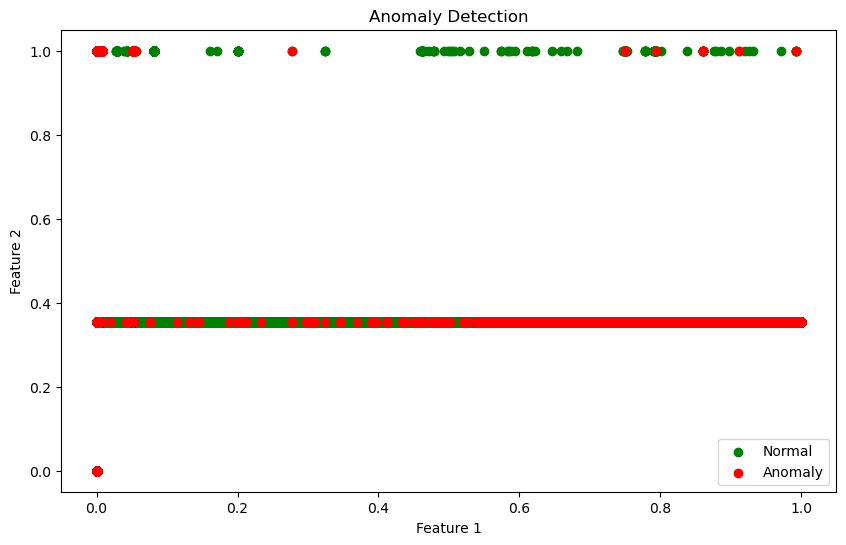

In [65]:
x_axis = test_x.iloc[:, 0] 
y_axis = test_x.iloc[:, 1]  
predictions_array = np.array(predictions)

# Create boolean masks
normal_points = predictions_array == 0
anomalies = predictions_array == 1

plt.figure(figsize=(10, 6))
plt.scatter(x_axis[normal_points], y_axis[normal_points], color='green', label='Normal')
plt.scatter(x_axis[anomalies], y_axis[anomalies], color='red', label='Anomaly')
plt.title('Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
save_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Save Plots\iso_basic_model_anomaly_detection.png'
plt.savefig(save_path)
plt.show()

In [48]:
plot_data = {
    "x_axis": x_axis.tolist(),  
    "y_axis": y_axis.tolist(),  
    "normal_points": normal_points.tolist(),  
    "anomalies": anomalies.tolist()  
}

anomaly_detection_plot = json.dumps(plot_data)

In [49]:
silhouette_score_for_db = silhouette_score(test_x, predictions)

In [50]:
silhouette_score_for_db

0.24906774

In [51]:
silhouette_score = float(silhouette_score_for_db)

## Sent Results to DB

In [52]:
# Not needed to send for ISO model
ruc_curve = None
auc_score = None
precision_recall_curve = None
feature_importance = None

cluster_centers = None
elbow_method_results = None
cluster_visualisation_plot = None

decision_function_values = None
support_vectors = None
one_class_svm_plot = None

In [60]:
# test object types

print(type(model_name))
print(type(model_parameters))
print(type(confusion_matrix))
print(type(accuracy_value))
print(type(precision_value))
print(type(recall_value))
print(type(f1_value))
print(type(ruc_curve))
print(type(auc_score))
print(type(precision_recall_curve))
print(type(feature_importance))
print(type(model_training_time))
print(type(silhouette_score)) 
print(type(cluster_centers))
print(type(elbow_method_results))
print(type(cluster_visualisation_plot)) 
print(type(anomaly_score))
print(type(anomaly_detection_plot))
print(type(decision_function_values)) 
print(type(support_vectors))
print(type(one_class_svm_plot))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'float'>
<class 'float'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'str'>
<class 'str'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>


In [61]:
# call and save to DB
insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot)

The model results have been inserted successfully
The Conneciton to MySQL is closed.


## Save model

In [62]:
# save model to file.

#save folder location
model_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\iso_model_baseline_basic_8.joblib"

# save model
dump(iso_model_baseline_basic, model_path)

['C:\\Users\\Kolobane\\OneDrive\\CIT MSc Data Science Modules\\_Semester Three - Final Project\\Project Two - Network Project\\ML Models\\iso_model_baseline_basic_8.joblib']

---

# **Isolate Forest Model Search: Attempt 3**

Next, we look at grid search to find the best model for Isolate forest.

Most influential hyperparameters:
 - n_estimators: Number of base estimators or trees in the ensemble.
 - max_samples: Number of samples to draw from the total dataset to train the estimator.
 - contamination: Represents the porportion of outliers in the dataset. Auto can can be used if unsure
     - We know that 13% are attack instances so this value will be used. contamination = 0.13
 - max-features: The Number of features to draw from the total features to train each base estimator.
 - bootstramp:Determines to draw samples with replacement or not.


## GridSearch for Isolate Forest

n_estimators_options = [100, 200, 300, 400, 500]
max_samples_options = [0.25, 0.5, 0.75, "auto]
contamination_options = [0.05, 0.1, 0.15, 0.2]

In [90]:
# Grid Search options for Isolate Forest

n_estimators_options = [100, 200, 300]
max_samples_options = [0.25, 0.5]
contamination_options = [0.1, 0.15]

best_score = -1
best_params = {}

for n_estimators in n_estimators_options:
    for max_samples in max_samples_options:
        for contamination in contamination_options:
            clf = IsolationForest(n_estimators=n_estimators, 
                                  max_samples=max_samples, 
                                  contamination=contamination, 
                                  random_state=42)
            clf.fit(train_x)
            predictions = clf.predict(test_x)
            score = silhouette_score(test_x, predictions)

            if score > best_score:
                best_score = score
                best_params = {
                    "n_estimators": n_estimators, 
                    "max_samples": max_samples, 
                    "contamination": contamination
                }

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.2740774
Best Parameters: {'n_estimators': 200, 'max_samples': 0.25, 'contamination': 0.15}


**Results from Best Search attempt 1: bad results. Run greater range of values**
define paramters to use in the grid search
- n_estimators_options = [200,300,400]
- max_samples_options = [0.5, "auto"]
- contamination = 0.13

Best Result is less than the Basic Model - Could be good for testing so will keep for now.

Best Score: 0.26775658
Best Parameters: {'n_estimators': 300, 'max_samples': 0.5, 'contamination': 0.13}

**Results from Best Search attempt 1: ??**

- n_estimators_options = [100, 200, 300]
- max_samples_options = [0.25, 0.5]
- contamination_options = [0.1, 0.15]

In [ ]:
Best Score: 0.2740774
Best Parameters: {'n_estimators': 200, 'max_samples': 0.25, 'contamination': 0.15}

In [91]:
# Set paramaters that the best model found
best_n_estimators = 200
best_max_samples = 0.25
best_contamination= 0.15

iso_model_baseline_best = IsolationForest(n_estimators=best_n_estimators, 
                                          max_samples=best_max_samples, 
                                          contamination=best_contamination, 
                                          random_state=42)

In [92]:
# Fit the model and get the training time.

# start timer
start_time = time.time()

# train the model
iso_model_baseline_best.fit(train_x)

# end timer
end_time = time.time()

## Explore the Results

In [93]:
# Prediations and Evualations
predictions = iso_model_baseline_best.predict(test_x)

In [124]:
# If you have true labels (test_y), you can evaluate the model
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00    669513
           1       0.17      0.83      0.28    137347

    accuracy                           0.14    806860
   macro avg       0.06      0.28      0.09    806860
weighted avg       0.03      0.14      0.05    806860



In [95]:
model_name = "iso_model_baseline_best"

In [96]:
model_parameters = json.dumps(iso_model_baseline_best.get_params())
model_parameters

'{"bootstrap": false, "contamination": 0.15, "max_features": 1.0, "max_samples": 0.25, "n_estimators": 200, "n_jobs": null, "random_state": 42, "verbose": 0, "warm_start": false}'

In [97]:
confusion_matrix_results = cm_function(test_y, predictions)
confusion_matrix_results

array([[     0,      0,      0],
       [ 96336,      0, 573177],
       [ 23468,      0, 113879]], dtype=int64)

In [125]:
confusion_matrix_results

array([[     0,      0,      0],
       [ 96336,      0, 573177],
       [ 23468,      0, 113879]], dtype=int64)

In [130]:
np.unique(test_y)

array([0, 1], dtype=int64)

In [98]:
confusion_matrix = confusion_matrix_results.tolist()
confusion_matrix

[[0, 0, 0], [96336, 0, 573177], [23468, 0, 113879]]

In [99]:
confusion_matrix = json.dumps(confusion_matrix)

In [100]:
report = classification_report(test_y, predictions, output_dict=True)

In [101]:
accuracy_value = report["accuracy"]
accuracy_value 

0.14113848746994523

In [102]:
precision_value = report["macro avg"]["precision"]
precision_value

0.05524974189391646

In [103]:
recall_value = report["macro avg"]["recall"]
recall_value

0.27637783618620476

In [104]:
f1_value = report["macro avg"]["f1-score"]
f1_value 

0.0920900740697612

In [105]:
model_training_time = end_time - start_time
model_training_time

1068.471934556961

In [106]:
anomaly_scores = iso_model_baseline_best.decision_function(test_x)
anomaly_scores

array([ 0.04727288,  0.0423047 , -0.0234602 , ...,  0.04183078,
        0.05418732,  0.05624928])

In [107]:
anomaly_scores_json = json.dumps(anomaly_scores.tolist())

In [108]:
anomaly_score = anomaly_scores_json

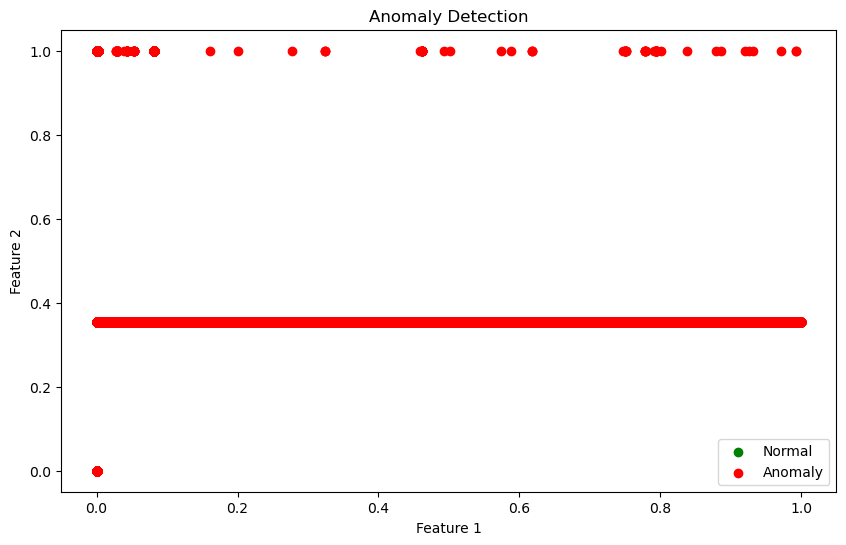

In [109]:
x_axis = test_x.iloc[:, 0] 
y_axis = test_x.iloc[:, 1]  
predictions_array = np.array(predictions)

# Create boolean masks
normal_points = predictions_array == 0
anomalies = predictions_array == 1

plt.figure(figsize=(10, 6))
plt.scatter(x_axis[normal_points], y_axis[normal_points], color='green', label='Normal')
plt.scatter(x_axis[anomalies], y_axis[anomalies], color='red', label='Anomaly')
plt.title('Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [110]:
plot_data = {
    "x_axis": x_axis.tolist(),  
    "y_axis": y_axis.tolist(),  
    "normal_points": normal_points.tolist(),  
    "anomalies": anomalies.tolist()  
}

anomaly_detection_plot = json.dumps(plot_data)

In [111]:
silhouette_score = silhouette_score(test_x, predictions)

In [112]:
silhouette_score = float(silhouette_score)

## Sent Results to DB

In [113]:
# Not needed to send for ISO model
ruc_curve = None
auc_score = None
precision_recall_curve = None
feature_importance = None

cluster_centers = None
elbow_method_results = None
cluster_visualisation_plot = None

decision_function_values = None
support_vectors = None
one_class_svm_plot = None

In [114]:
# test object types

print(type(model_name))
print(type(model_parameters))
print(type(confusion_matrix))
print(type(accuracy_value))
print(type(precision_value))
print(type(recall_value))
print(type(f1_value))
print(type(model_training_time))
print(type(silhouette_score)) 
print(type(anomaly_score))
print(type(anomaly_detection_plot))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'str'>
<class 'str'>


In [115]:
# call and save to DB
insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot)

The model results have been inserted successfully
The Conneciton to MySQL is closed.


## Save the best Model

In [116]:
# save model to file.

#save folder location
model_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\iso_model_baseline_best_2.joblib"

# save model
dump(iso_model_baseline_best, model_path)

['C:\\Users\\Kolobane\\OneDrive\\CIT MSc Data Science Modules\\_Semester Three - Final Project\\Project Two - Network Project\\ML Models\\iso_model_baseline_best_2.joblib']

---

---

# **One Class SVM Basic Model**

The training is taking a huge amount of time. Either running for days or crashing my machine regularlly

## Basic Kernel: RBF - Radical Basis Function

In [1]:
# Initialize One-Class SVM # default settings
oc_svm = OneClassSVM()

NameError: name 'OneClassSVM' is not defined

#### 0.0001% in pandas

In [142]:
# Take 1% sample
sample_data_1_perc = normal_data.sample(frac=0.0001, random_state=42)
sample_data_1_perc.shape

NameError: name 'normal_data' is not defined

In [2]:
# # start timer
# start_time = time.time()

# # Train the model only on normal data
# oc_svm.fit(sample_data_1_perc)

# end_time = time.time()

09.18 am Friday started training model.

In [3]:
# training_time =  end_time - start_time
# training_time 

#### 0.001% in pandas

In [ ]:
# sample_data_1_perc = normal_data.sample(frac=0.001, random_state=42)
# sample_data_1_perc.shape

In [ ]:
# # start timer
# start_time = time.time()

# # Train the model only on normal data
# oc_svm.fit(sample_data_1_perc)

# end_time = time.time()

In [ ]:
# training_time =  end_time - start_time
# training_time 

#### 0.01% in pandas

In [ ]:
# sample_data_1_perc = normal_data.sample(frac=0.01, random_state=42)
# sample_data_1_perc.shape

In [ ]:
# # start timer
# start_time = time.time()

# # Train the model only on normal data
# oc_svm.fit(sample_data_1_perc)

# end_time = time.time()

In [ ]:
# training_time =  end_time - start_time
# training_time 

#### 0.1% in pandas - 

In [147]:
sample_data_1_perc = train_x.sample(frac=0.001, random_state=42)
sample_data_1_perc.shape

(6455, 70)

In [148]:
# start timer
start_time = time.time()

# Train the model only on normal data
oc_svm.fit(sample_data_1_perc)

end_time = time.time()

In [149]:
training_time =  end_time - start_time
training_time 

1.823887825012207

#### 0.0001% in numpy.

In [ ]:
# # Take 1% sample
# sample_data_1_perc = normal_data.sample(frac=0.0001, random_state=42)
# sample_data_1_perc.shape

In [ ]:
# sample_data_1_perc_numpy = sample_data_1_perc.to_numpy()

In [ ]:
# # start timer
# start_time = time.time()

# # Train the model only on normal data
# oc_svm.fit(sample_data_1_perc_numpy)

# end_time = time.time()

In [ ]:
# training_time =  end_time - start_time
# training_time 

#### 0.01% in numpy.

In [ ]:
# # Take 1% sample
# sample_data_1_perc = normal_data.sample(frac=0.001, random_state=42)
# sample_data_1_perc.shape

In [ ]:
# sample_data_1_perc_numpy = sample_data_1_perc.to_numpy()

In [ ]:
# # start timer
# start_time = time.time()

# # Train the model only on normal data
# oc_svm.fit(sample_data_1_perc_numpy)

# end_time = time.time()

In [ ]:
# training_time =  end_time - start_time
# training_time 

#### 0.1% in numpy - LOOK AND COMPARE THIS

In [ ]:
# # Take 1% sample
# sample_data_1_perc = normal_data.sample(frac=0.1, random_state=42)
# sample_data_1_perc.shape

In [ ]:
# sample_data_1_perc_numpy = sample_data_1_perc.to_numpy()

In [ ]:
# # start timer
# start_time = time.time()

# # Train the model only on normal data
# oc_svm.fit(sample_data_1_perc_numpy)

# end_time = time.time()

In [ ]:
# training_time =  end_time - start_time
# training_time 

## Change kernel:Linear

In [10]:
# # Initialize One-Class SVM # default settings
# oc_svm = OneClassSVM(kernel="linear", nu=0.1)

In [12]:
# # Take 1% sample
# sample_data_10_perc = train_x.sample(frac=0.001, random_state=42)
# sample_data_10_perc.shape

(6455, 70)

In [ ]:
# # start timer
# start_time = time.time()

# # Train the model only on normal data
# oc_svm.fit(sample_data_1_perc)

# end_time = time.time()

In [ ]:
# training_time =  end_time - start_time
# training_time 

## This model will be used as the basic model for one class SVM -  COMPLETED 

In [ ]:
# Take 10% sample
sample_data_1_perc = train_x.sample(frac=0.1, random_state=42)
sample_data_1_perc.shape

In [ ]:
# start timer
start_time = time.time()

# Train the model only on normal data
oc_svm.fit(sample_data_1_perc)

end_time = time.time()

In [ ]:
training_time =  end_time - start_time
training_time 

16000 seconds.

In [ ]:
# Predictions
predictions = oc_svm.predict(test_x)

In [ ]:
predictions

## Explore Results

In [ ]:
model_name = "oc_svm_model_baseline_basic"

In [ ]:
model_parameters = oc_svm.get_params()

In [ ]:
model_parameters = json.dumps(model_parameters)
type(model_parameters)

In [ ]:
model_training_time = end_time - start_time
model_training_time

In [ ]:
decision_function_values = oc_svm.decision_function(test_x)

In [ ]:
decision_function_values

In [ ]:
type(decision_function_values)

In [ ]:
support_vectors = oc_svm.support_vectors_

In [ ]:
support_vectors

In [ ]:
type(support_vectors)

70 features so I difficult to do a plot of the support vectors.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Reducing the dimensions of the data to 2D
pca = PCA(n_components=2)
train_x_2d = pca.fit_transform(train_x)
test_x_2d = pca.transform(test_x)

# Create a grid for visualization
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_transformed = pca.inverse_transform(grid_data)

# Decision function on the grid
Z = oc_svm.decision_function(grid_data_transformed)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))

# Plot decision boundary
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')

# Plot data points
plt.scatter(train_x_2d[:, 0], train_x_2d[:, 1], c='white', s=20, edgecolor='k')
plt.scatter(test_x_2d[:, 0], test_x_2d[:, 1], c='blue', s=20, edgecolor='k')

plt.title("One-Class SVM (2D Projection)")
plt.show()


In [ ]:
# map predictions to -1 to 1
cluster_labels = (predictions +1) //2
silhouette_score_avg = silhouette_score(test_x, cluster_labels)
silhouette_score_avg

In [ ]:
# Calculate the decision function values (as you've already done)
decision_function_values = oc_svm.decision_function(test_x)

# ROC AUC Curve
fpr, tpr, _ = roc_curve(true_labels, -decision_function_values)  # Note: Flip the sign for SVM output
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, -decision_function_values)  # Flip the sign for SVM output
average_precision = average_precision_score(true_labels, -decision_function_values)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP = {:.2f})'.format(average_precision))
plt.show()

In [ ]:
# values that are not needed.
# Random forest
confusion_matrix = None
accuracy_value =None
precision_value = None
recall_value = None
f1_value = None
ruc_curve = None
auc_score = None
ruc_curve = None
auc_score = None
precision_recall_curve = None
feature_importance = None

# Kemans
cluster_centers = None
elbow_method_results = None
cluster_visualisation_plot = None

# Isolate Forest
anomaly_score = None
anomaly_detection_plot = None

In [ ]:
Stop here

In [ ]:
# test object types

print(type(model_name))
print(type(model_parameters)) 
print(type(confusion_matrix)) # Not used
print(type(accuracy_value)) # Not used
print(type(precision_value)) # Not used
print(type(recall_value)) # Not used
print(type(f1_value)) # Not used
print(type(ruc_curve)) 
print(type(auc_score))
print(type(precision_recall_curve)) 
print(type(feature_importance)) # Not used
print(type(model_training_time))
print(type(silhouette_score)) 
print(type(cluster_centers)) # Not used
print(type(elbow_method_results)) # Not used
print(type(cluster_visualisation_plot)) # Not used
print(type(anomaly_score)) # Not used
print(type(anomaly_detection_plot))# Not used
print(type(decision_function_values)) # Not used
print(type(support_vectors))
print(type(one_class_svm_plot))

In [ ]:
# call and save to DB
insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot)

## Sent Results to DB

## Save Model

In [ ]:
# save model to file.

#save folder location
model_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\??????.joblib"

# save model
dump(?????, model_path)

---

# **One Class SVM Model Search**

## GridSearch for SVM

## Explore the Results

---

In [ ]:
print("Full notebook ran and finished with no errors. Yipee!")

# **Decision Tree: Hoeffding Tree Basic Model**

In [8]:
from skmultiflow.trees import HoeffdingTreeClassifier

In [23]:
hoeffding_tree_model_basic = HoeffdingTreeClassifier()

In [30]:
# get the start time
start_time = time.time()

hoeffding_tree_model_basic.fit(train_x.to_numpy(), train_y.to_numpy())

# record the end time.
end_time = time.time()

In [31]:
# Test the model against the test 
test_predictions = hoeffding_tree_model_basic.predict(val_test_x.to_numpy())

In [32]:
model_name = "hoef_model_baseline_basic"
model_name

'hoef_model_baseline_basic'

In [33]:
model_parameters = hoeffding_tree_model_basic.get_params()

In [61]:
model_parameters = json.dumps(model_parameters)

In [35]:
confusion_matrix = confusion_matrix(val_test_y, test_predictions)

In [36]:
confusion_matrix = confusion_matrix.tolist()

In [37]:
confusion_matrix = model_parameters

In [39]:
accuracy_value = float(accuracy_score(val_test_y, test_predictions))
precision_value = float(precision_score(val_test_y, test_predictions))
recall_value = float(recall_score(val_test_y, test_predictions))
f1_value = float(f1_score(val_test_y, test_predictions))

In [40]:
accuracy_value, precision_value, recall_value, f1_value

(0.9901990371309999, 0.9964636662805594, 0.9457796675573548, 0.970460352324174)

In [42]:
val_test_x_np = val_test_x.to_numpy()
probabilities = hoeffding_tree_model_basic.predict_proba(val_test_x_np)


fpr, tpr, thresholds = roc_curve(val_test_y, probabilities[:, 1])
auc_score = float(auc(fpr, tpr))

In [43]:
# Area under the curve score.
auc_score

0.9975081970621167

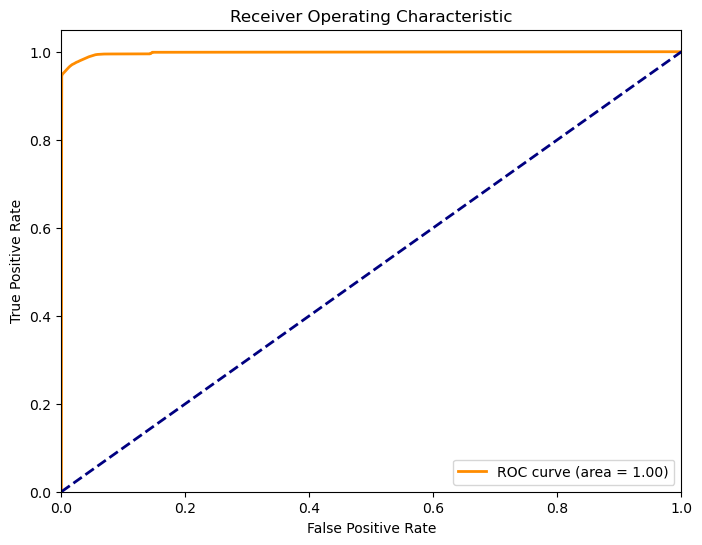

In [44]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [45]:
# Send the ROC Curve to the DB as a JSON object.

# convert the ROC Curve to JSON
roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_auc": auc_score
}


ruc_curve = json.dumps(roc_data)

In [46]:
precision, recall, _ = precision_recall_curve(val_test_y, probabilities[:, 1])

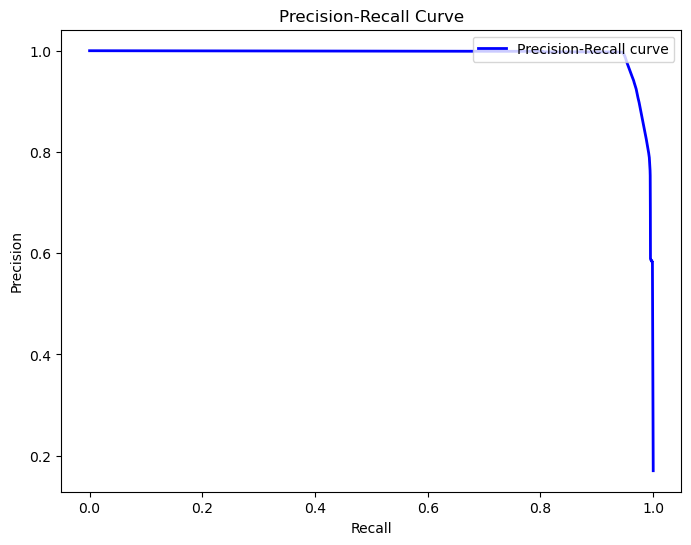

In [47]:
# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [48]:
# Send the Precision Recall Curve to the DB as a JSON object.

pr_data = {
    "precision": precision.tolist(), 
    "recall": recall.tolist()
}


precision_recall_curve = json.dumps(pr_data)

In [54]:
feature_importance = None

In [56]:
model_training_time = end_time - start_time
model_training_time

1396.5857310295105

### Sent Results to DB

In [52]:
# Kemans
silhouette_score = None
cluster_centers = None
elbow_method_results = None
cluster_visualisation_plot = None

# Isolate Forest
anomaly_score = None
anomaly_detection_plot = None

# One Class SVM
decision_function_values = None
support_vectors = None
one_class_svm_plot = None

In [62]:
# Need to check the object types so that the DB can handle them

#DONE. Objects ok now.

print(type(model_name))
print(type(model_parameters))
print(type(confusion_matrix))
print(type(accuracy_value))
print(type(precision_value))
print(type(recall_value))
print(type(f1_value))
print(type(ruc_curve))
print(type(auc_score))
print(type(precision_recall_curve))
print(type(feature_importance))
print(type(model_training_time))
print(type(silhouette_score)) 
print(type(cluster_centers))
print(type(elbow_method_results))
print(type(cluster_visualisation_plot)) 
print(type(anomaly_score))
print(type(anomaly_detection_plot))
print(type(decision_function_values)) 
print(type(support_vectors))
print(type(one_class_svm_plot))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'NoneType'>
<class 'float'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>


In [63]:
insert_model_results_to_db(config, model_name, model_parameters, confusion_matrix, # note the config is the conneciton details, username, pw, host, etc
                                accuracy_value, precision_value, recall_value, f1_value, 
                                ruc_curve, auc_score, precision_recall_curve, feature_importance, model_training_time, 
                                silhouette_score, cluster_centers, elbow_method_results, 
                                cluster_visualisation_plot, anomaly_score, anomaly_detection_plot, 
                                decision_function_values, support_vectors, one_class_svm_plot)

The model results have been inserted successfully
The Conneciton to MySQL is closed.


## Save Model

In [90]:
# save pickle parts
model_params = hoeffding_tree_model_basic.get_params()

params_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\hoef_model_basic_params.json"

# Save to a json file
with open(params_path, 'w') as file:
    json.dump(model_params, file)

In [81]:
# #save folder location
# model_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\hoef_model_basic.joblib"

# # save model
# dump(hoeffding_tree_model_basic, model_path)
# could not save model with pickle. saved paramters instead

In [89]:
print(f"Model parameters saved to {params_path}")

Model parameters saved to C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\hoef_model_basic_params.json
